<a href="https://colab.research.google.com/github/dieko95/AlgoTrading/blob/master/Backtesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Data

#### Install Library

In [1]:
### Install bt package

!pip install bt
!pip install pydrive

     |████████████████████████████████| 2.7MB 3.4MB/s 
  Stored in directory: /root/.cache/pip/wheels/ae/8a/a2/a679757e4e7219e6f17727d1422d4ce32da847678c6559da35
  Stored in directory: /root/.cache/pip/wheels/20/08/4d/921180e81279d147cb6399fe1e194f2c67a796df86f9f4c5fe
Successfully built bt ffn
     |████████████████████████████████| 993kB 3.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built pydrive


### Authenticate Google 

In [0]:

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


### Load Data from Drive 

In [0]:
import pandas as pd  

file_id = '1hA1Iq3N-T84Gq6xZm1WDhcycCxqay16Z'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('ReturnPredictions-SimpleRegTreeNoParam_v0.1.csv')

Return = pd.read_csv('ReturnPredictions-SimpleRegTreeNoParam_v0.1.csv')

## Index as TimeStamp DateTime type 



In [4]:
Return.timeStamp = pd.to_datetime(Return.timeStamp) 
Return.set_index(Return["timeStamp"],inplace=True)

# Return = Return['predictedReturns']
Return.head()

,Unnamed: 0,timeStamp,predictedReturns
timeStamp,,,
2014-01-02,0,2014-01-02,-0.000896
2014-01-03,1,2014-01-03,0.010039
2014-01-04,2,2014-01-04,0.000000
2014-01-05,3,2014-01-05,0.000000
2014-01-06,4,2014-01-06,0.019169


### Creating 1 Day Lag

In [5]:
# retOff = Return.index + pd.DateOffset(day=1)
returnOffset = Return.shift(1) # https://www.geeksforgeeks.org/python-pandas-dataframe-shift/
returnOffset.head()

,Unnamed: 0,timeStamp,predictedReturns
timeStamp,,,
2014-01-02,NaN,NaT,NaN
2014-01-03,0.0,2014-01-02,-0.000896
2014-01-04,1.0,2014-01-03,0.010039
2014-01-05,2.0,2014-01-04,0.000000
2014-01-06,3.0,2014-01-05,0.000000


## Creating the Strategy

In [0]:
# Creating Signal Variable
signal = Return['predictedReturns'] 
signal_offset = returnOffset['predictedReturns'] 
signal = pd.DataFrame(signal)
signal_offset = pd.DataFrame(signal_offset)
signal1 = signal.rename(columns={'predictedReturns':'rht_base'})
signal2 = signal.rename(columns={'predictedReturns':'rht_Strategy_2'})
signal3 = signal_offset.rename(columns={'predictedReturns':'rht_Strategy_3'})

# Creating Weights 
tw_1 = signal1.copy()
tw_2 = signal2.copy()
tw_3 = signal3.copy()

# Assign weight number for each type of signal strength
WeightStrongLong = 1.0
WeightMediumLong = 0.5
WeightWeak = 0
WeightMediumShort = -0.5
WeightStrongShort = -1.0


# Match the signal strength with the assigned weight
tw_1[signal1 > 0.02 ] = WeightStrongLong
tw_1[(signal1 >= 0.01) & (signal1 <= 0.02)] = WeightMediumLong
tw_1[(signal1 >= -0.01) & (signal1 <= 0.01)] = WeightWeak
tw_1[(signal1 <= -0.01) & (signal1 >= -0.02)] = WeightMediumShort
tw_1[signal1 < -0.02] = WeightStrongShort
tw_1[tw_1.isnull()] = 0 


# Do the same thing with signal2
tw_2[signal2 > 0.02 ] = WeightStrongLong
tw_2[(signal2 >= 0.01) & (signal2 <= 0.02)] = WeightMediumLong
tw_2[(signal2 >= -0.01) & (signal2 <= 0.01)] = WeightWeak
tw_2[(signal2 <= -0.01) & (signal2 >= -0.02)] = WeightMediumShort
tw_2[signal2 < -0.02] = WeightStrongShort
tw_2[tw_2.isnull()] = 0 


# Do the same thing with signal_offset
tw_3[signal3 > 0.02 ] = WeightStrongLong
tw_3[(signal3 >= 0.01) & (signal3 <= 0.02)] = WeightMediumLong
tw_3[(signal3 >= -0.01) & (signal3 <= 0.01)] = WeightWeak
tw_3[(signal3 <= -0.01) & (signal3 >= -0.02)] = WeightMediumShort
tw_3[signal3 < -0.02] = WeightStrongShort
tw_3[tw_3.isnull()] = 0 




In [0]:
%matplotlib inline


#import bt package
import bt

# fetch some data
data1 = bt.get( 'rht', start='2014-01-02', end= '2018-12-30')
data2 = bt.get( 'rht', start='2014-01-02', end= '2018-12-30')
data3 = bt.get( 'rht', start='2014-01-02', end= '2018-12-30')

data1 = data1.rename(columns={'rht':'rht_base'})
data2 = data2.rename(columns={'rht':'rht_Strategy_2'})
data3 = data3.rename(columns={'rht':'rht_Strategy_3'})



# # create the strategy
base = bt.Strategy('Base Strategy', [bt.algos.SelectWhere(signal1),
                        bt.algos.WeighTarget(tw_1),
                        bt.algos.Rebalance()])

s2 = bt.Strategy('Strategy 2', [bt.algos.SelectWhere(signal2),
                        bt.algos.WeighTarget(tw_2),
                        bt.algos.LimitDeltas(), 
                        bt.algos.Rebalance()])

s3 = bt.Strategy('Strategy 3', [bt.algos.SelectWhere(signal3),
                        bt.algos.WeighTarget(tw_3),
                        bt.algos.LimitDeltas(), 
                        bt.algos.Rebalance()])



# Include Default comissions, we have realistic comissions

# s1.adjust(1000000,fee=0.1)
# # s1.commission_fn(getFee(10,5))

## Running Backtest


Base Strategy
0% [############################# ] 100% | ETA: 00:00:00Strategy 2
0% [############################# ] 100% | ETA: 00:00:00Strategy 3
0% [############################# ] 100% | ETA: 00:00:00Stat                 Base Strategy    Strategy 2    Strategy 3
-------------------  ---------------  ------------  ------------
Start                2014-01-01       2014-01-01    2014-01-01
End                  2018-12-28       2018-12-28    2018-12-28
Risk-free rate       0.64%            0.64%         0.64%

Total Return         40323.22%        126.42%       1.83%
Daily Sharpe         4.23             1.94          -0.05
Daily Sortino        5.75             2.41          -0.06
CAGR                 233.08%          17.80%        0.36%
Max Drawdown         -49.75%          -19.12%       -7.04%
Calmar Ratio         4.69             0.93          0.05

MTD                  1.38%            2.00%         1.73%
3m                   -44.84%          -12.63%       -3.27%
6m               

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


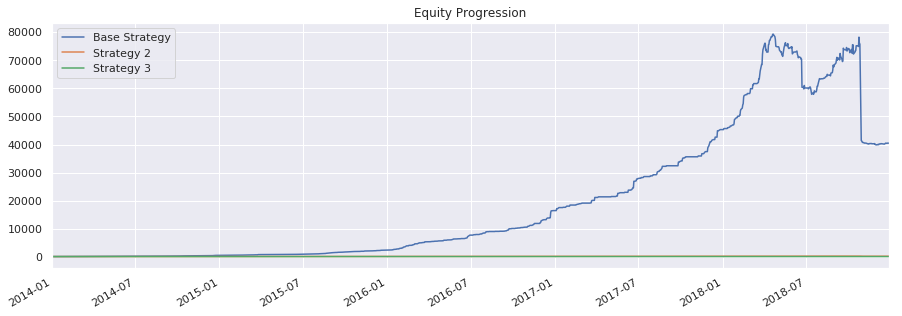

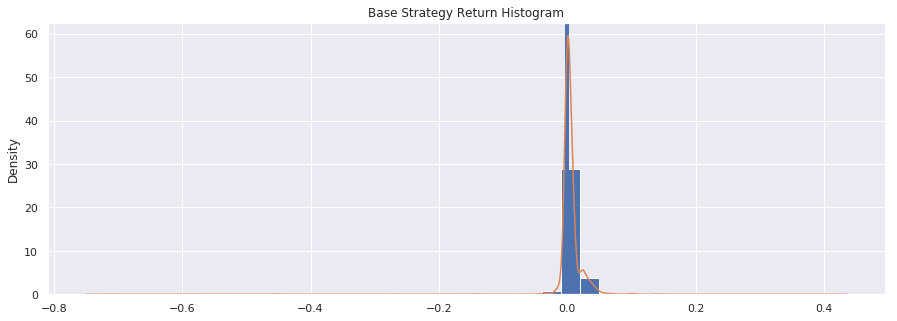

In [9]:
%matplotlib inline

import seaborn as sns
sns.set()


# We will need the risk-free rate to get correct Sharpe Ratios 
riskfree =  bt.get('^IRX', start= '2014-01-02', end= '2018-12-30')
# Take the average of the risk free rate over entire time period
riskfree_rate = float(riskfree.mean()) / 100 
# riskfree_rate = float(riskfree +1)^(1/250)+1


# create a backtest and run it
test1 = bt.Backtest(base, data1, commissions=lambda q, p: max(1, abs(q) * 0.01))
test2 = bt.Backtest(s2, data2, commissions=lambda q, p: max(1, abs(q) * 0.01))
test3 = bt.Backtest(s3, data3, commissions=lambda q, p: max(1, abs(q) * 0.01))

# res = bt.run(test3)
# res = bt.run(test1, test2)
res = bt.run(test1, test2, test3)

res.set_riskfree_rate(riskfree_rate)

# first let's see an equity curve
res.plot()

# ok and what about some stats?
res.display()

# ok and how does the return distribution look like?
res.plot_histogram()






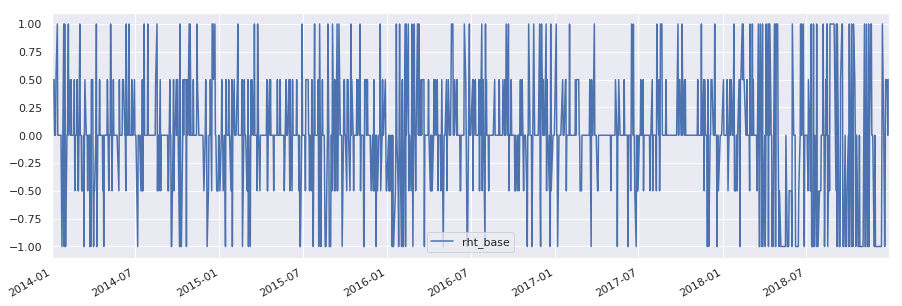

In [11]:
# and just to make sure everything went along as planned, let's plot the security weights over time
res.plot_security_weights()

In [12]:
res.display_lookback_returns()


,Base Strategy,Strategy 2,Strategy 3
mtd,1.38%,2.00%,1.73%
3m,-44.84%,-12.63%,-3.27%
6m,-32.77%,-13.28%,-4.25%
ytd,-10.79%,-0.11%,-0.43%
1y,-10.79%,-0.11%,-0.43%
3y,157.09%,13.78%,0.34%
5y,233.08%,17.80%,0.36%
10y,233.08%,17.80%,0.36%
incep,233.08%,17.80%,0.36%


## Getting Transactions per Day

In [13]:

# Get Transactions
import seaborn as sns
trans = res.get_transactions()
type(trans)

pandas.core.frame.DataFrame

In [14]:
# We can view Montly Returns as well
res.display_monthly_returns(0)

  Year    Jan    Feb    Mar    Apr    May     Jun    Jul    Aug    Sep     Oct    Nov    Dec     YTD
------  -----  -----  -----  -----  -----  ------  -----  -----  -----  ------  -----  -----  ------
  2014  19.21  10.74  22.12  19.91   6.6    10.8   12.91   6.18  11.55   29.38   3.47  28.96  427.13
  2015  12.97   7.87  26.22   3.95   3.48    8.89  12.77  34.03  20.19   11.5   11     12.7   356.47
  2016  26.96  44.93  20.94   6.51  12.06   21.03   9.7    6.89  11.35    4.71  15.38  34.98  584.54
  2017   9.65   5.97  10.51   1.04   6.9    21.95   3.51  12.48   4.65    4.96  10.01  15.6   175.1
  2018   9.43  17.29  26.79   1.42   0.04  -19.63   5.4    7.69   7.39  -44.2   -2.5    1.38  -10.79


## Strategy with Benchmark

spyBench
0% [############################# ] 100% | ETA: 00:00:00Stat                 spyBench    Strategy 3
-------------------  ----------  ------------
Start                2014-01-01  2014-01-01
End                  2018-12-28  2018-12-28
Risk-free rate       0.00%       0.00%

Total Return         49.54%      1.83%
Daily Sharpe         0.68        0.11
Daily Sortino        1.05        0.15
CAGR                 8.40%       0.36%
Max Drawdown         -19.35%     -7.04%
Calmar Ratio         0.43        0.05

MTD                  -9.60%      1.73%
3m                   -14.28%     -3.27%
6m                   -7.59%      -4.25%
YTD                  -5.40%      -0.43%
1Y                   -5.75%      -0.43%
3Y (ann.)            8.60%       0.34%
5Y (ann.)            8.40%       0.36%
10Y (ann.)           8.40%       0.36%
Since Incep. (ann.)  8.40%       0.36%

Daily Sharpe         0.68        0.11
Daily Sortino        1.05        0.15
Daily Mean (ann.)    8.94%       0.45%
Daily Vol (an

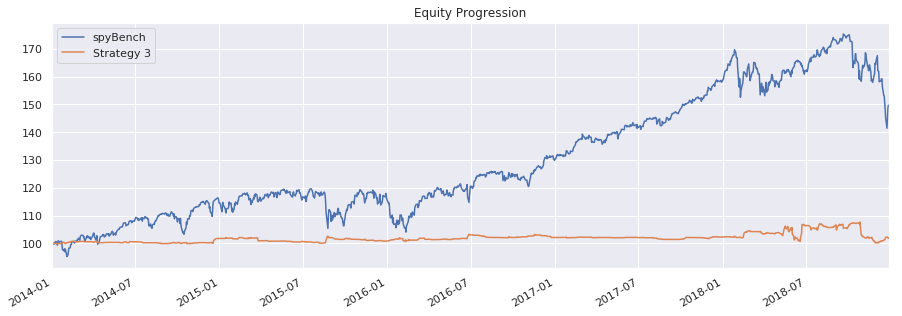

In [18]:
import matplotlib.pyplot as plt

sns.set()
# sns.set(style="ticks", context="talk")
# plt.style.use("dark_background")
  
# benchmark = long_only_ew('spy', name='spy')






#data['predictedReturns'] = Return['predictedReturns']


# signal = Return['predictedReturns'] #> 0.01

# signal = pd.DataFrame(signal)
# signal = signal.rename(columns={'predictedReturns':'rht'})

# We will need the risk-free rate to get correct Sharpe Ratios 
riskfree =  bt.get('^IRX', start= '2014-01-02', end= '2018-12-30')

# Take the average of the risk free rate over entire time period
riskfree_rate = float(riskfree.mean()) / 100 


dataBench = bt.get( 'spy', start='2014-01-02', end= '2018-12-30')


# # create the strategy
sBench = bt.Strategy('spyBench', [bt.algos.RunOnce(),
                           bt.algos.SelectAll(),
                           bt.algos.WeighEqually(),
                           bt.algos.Rebalance()])

testBench = bt.Backtest(sBench, dataBench, commissions=lambda q, p: max(1, abs(q) * 0.01))


res2 = bt.run(testBench,test3)
res2.display()
res2.plot()
# res2.weights()


In [0]:
tw_1